Adapted from https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/solutions/RL_Solution.ipynb

In [1]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.utils.vis_utils import plot_model

# Cartpole

https://gym.openai.com/envs/CartPole-v1/

In [2]:
import skvideo.io
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

Example, untrained agent, samples action randomly from action space:

In [3]:
filename = "random.mp4"
output_video = skvideo.io.FFmpegWriter(filename)

env = gym.make("CartPole-v0")

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

output_video.close()
env.close()

[-0.0307154   0.00493251 -0.03780593  0.0071278 ]
[-0.03061675  0.20057568 -0.03766338 -0.29723956]
[-0.02660524  0.00601031 -0.04360817 -0.01666888]
[-0.02648503 -0.18846    -0.04394154  0.26194252]
[-0.03025423  0.00726075 -0.03870269 -0.04426988]
[-0.03010902  0.20291569 -0.03958809 -0.34890827]
[-0.02605071  0.0083785  -0.04656626 -0.06896696]
[-0.02588314 -0.18604598 -0.0479456   0.20866808]
[-0.02960405 -0.38045074 -0.04377223  0.48584951]
[-0.03721307 -0.57492856 -0.03405524  0.76442189]
[-0.04871164 -0.37935459 -0.01876681  0.46122072]
[-0.05629873 -0.18397248 -0.00954239  0.16268206]
[-0.05997818  0.01128476 -0.00628875 -0.1329959 ]
[-0.05975249  0.20649623 -0.00894867 -0.42765619]
[-0.05562256  0.01150215 -0.01750179 -0.13780766]
[-0.05539252 -0.1833648  -0.02025795  0.14930275]
[-0.05905982  0.01204129 -0.01727189 -0.14970168]
[-0.05881899 -0.18282913 -0.02026592  0.13748267]
[-0.06247557 -0.37765504 -0.01751627  0.42370375]
[-0.07002867 -0.57252453 -0.0090422   0.71081362]


Dimension of state and action spaces:



In [4]:
space_dim = 4
action_dim = 2

## Agent:

It is a neural network that receives the state (observation) as input and gives a probability over the action space as output.

In [5]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=space_dim),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=action_dim, activation=None) # No activation funtion!!!
  ])
  return model

cartpole_model = create_cartpole_model()

In [6]:
print(cartpole_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________
None


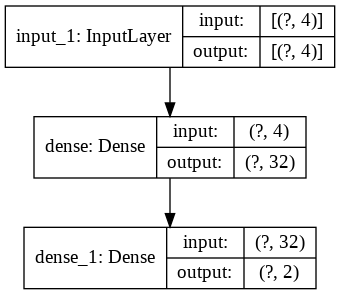

In [7]:
plot_model(cartpole_model, show_shapes=True, show_layer_names=True)

Function that, given the model and the state (observation), gives an action sampled from the model:

In [8]:
def choose_action(model, state):
  # Add batch dimension to the state:
  state = state[None, :]

  # Get log probabilities for each action:
  logits = model.predict(state)

  # Get true probabilities  with softmax function:
  probs = tf.nn.softmax(logits).numpy()
  
  # Sample action:
  action = np.random.choice(action_dim, size=1, p=probs.flatten())[0] 

  return action

At this point we can use our agent in the problem, but it will perform as the random case:

In [9]:
filename = "untrained_nn.mp4"
output_video = skvideo.io.FFmpegWriter(filename)

env = gym.make("CartPole-v0")

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        print(observation)
        action = choose_action(cartpole_model, observation)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

output_video.close()
env.close()

[-0.04413048  0.00337851 -0.04108083  0.03459379]
[-0.04406291 -0.19113099 -0.04038895  0.31403751]
[-0.04788553 -0.38565501 -0.0341082   0.59371446]
[-0.05559863 -0.58028335 -0.02223391  0.8754613 ]
[-0.0672043  -0.38486633 -0.00472469  0.57587198]
[-0.07490162 -0.57992173  0.00679275  0.86706277]
[-0.08650006 -0.38489287  0.02413401  0.57652328]
[-0.09419792 -0.19011738  0.03566447  0.29153983]
[-0.09800026 -0.38572922  0.04149527  0.59525415]
[-0.10571485 -0.58140661  0.05340035  0.90071368]
[-0.11734298 -0.38704731  0.07141463  0.62528256]
[-0.12508393 -0.58308973  0.08392028  0.93957468]
[-0.13674572 -0.77923654  0.10271177  1.25740308]
[-0.15233045 -0.58556811  0.12785983  0.99857564]
[-0.16404181 -0.39236574  0.14783135  0.74862619]
[-0.17188913 -0.58918408  0.16280387  1.08393788]
[-0.18367281 -0.78603563  0.18448263  1.42296384]
Episode finished after 17 timesteps
[0.04495713 0.00316106 0.01311022 0.02577236]
[ 0.04502035  0.19809257  0.01362567 -0.26274548]
[0.04898221 0.0027

Memory:

In [10]:
class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      self.actions.append(new_action) 
      self.rewards.append(new_reward) 
        
memory = Memory()

Reward function:

In [11]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

Loss function:

In [12]:
def compute_loss(logits, actions, rewards): 
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions) 

  # Scale loss with reward:  
  loss = tf.reduce_mean( neg_logprob * rewards ) 

  return loss

Training step:

In [13]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      logits = model(observations)
      loss = compute_loss(logits, actions, discounted_rewards)

  grads = tape.gradient(loss, model.trainable_variables) 
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

Train model:

In [14]:
%%time

env = gym.make("CartPole-v0")

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

rewards = []
num_episodes = 2000

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(num_episodes):

  # Restart the environment
  observation = env.reset()
  memory.clear()

  while True:
      # using our observation, choose an action and take it in the environment
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      # add to memory
      memory.add_to_memory(observation, action, reward)
      
      # is the episode over? did you crash or do so well that you're done?
      if done:
          # determine total reward and keep a record of this
          total_reward = sum(memory.rewards)
          rewards.append(total_reward)
          
          # initiate training - remember we don't know anything about how the 
          #   agent is doing until it has crashed!
          train_step(cartpole_model, optimizer, 
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          print("Episode %d: reward = %f" % (i_episode, total_reward))
          break
      # update our observatons
      observation = next_observation

env.close()

Episode 0: reward = 16.000000
Episode 1: reward = 27.000000
Episode 2: reward = 42.000000
Episode 3: reward = 21.000000
Episode 4: reward = 42.000000
Episode 5: reward = 10.000000
Episode 6: reward = 38.000000
Episode 7: reward = 48.000000
Episode 8: reward = 57.000000
Episode 9: reward = 22.000000
Episode 10: reward = 25.000000
Episode 11: reward = 100.000000
Episode 12: reward = 42.000000
Episode 13: reward = 24.000000
Episode 14: reward = 39.000000
Episode 15: reward = 17.000000
Episode 16: reward = 16.000000
Episode 17: reward = 39.000000
Episode 18: reward = 23.000000
Episode 19: reward = 17.000000
Episode 20: reward = 21.000000
Episode 21: reward = 13.000000
Episode 22: reward = 13.000000
Episode 23: reward = 16.000000
Episode 24: reward = 20.000000
Episode 25: reward = 35.000000
Episode 26: reward = 13.000000
Episode 27: reward = 11.000000
Episode 28: reward = 20.000000
Episode 29: reward = 23.000000
Episode 30: reward = 29.000000
Episode 31: reward = 40.000000
Episode 32: rewar

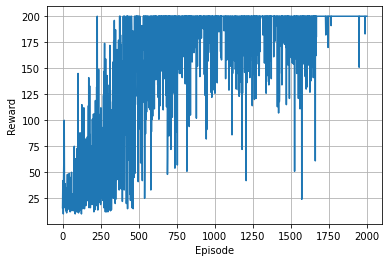

In [15]:
plt.figure()
plt.plot(rewards)
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Create video with the trained agent:

In [20]:
filename = "trained_nn.mp4"
output_video = skvideo.io.FFmpegWriter(filename)

env = gym.make("CartPole-v0")

for i_episode in range(10):
    observation = env.reset()
    for t in range(1000):
        
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        #print(observation)
        action = choose_action(cartpole_model, observation)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode {} finished after {} timesteps".format(i_episode, t+1))
            break

output_video.close()
env.close()

Episode 0 finished after 198 timesteps
Episode 1 finished after 200 timesteps
Episode 2 finished after 200 timesteps
Episode 3 finished after 200 timesteps
Episode 4 finished after 200 timesteps
Episode 5 finished after 200 timesteps
Episode 6 finished after 200 timesteps
Episode 7 finished after 200 timesteps
Episode 8 finished after 200 timesteps
Episode 9 finished after 200 timesteps


### Exercises:

- Improve the model for the cartpole problem

- Use RL in other environments